# EEG Data Analysis


MNE Documentation: https://mne.tools/stable/auto_tutorials/stats-sensor-space/20_erp_stats.html#footcite-smithnichols2009

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import mne

# Load Data
path = mne.datasets.kiloword.data_path() / 'kword_metadata-epo.fif'
epochs = mne.read_epochs(path)

Reading /Users/jacobloranger/mne_data/MNE-kiloword-data/kword_metadata-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -100.00 ...     920.00 ms
        0 CTF compensation matrices available
Adding metadata with 8 columns
960 matching events found
No baseline correction applied
0 projection items activated


In [2]:
epochs.decimate(4, verbose='error')
name = "NumberOfLetters"

# Split up the data by the median length in letters via the attached metadata
median_value = str(epochs.metadata[name].median())
long_words = epochs[name + " > " + median_value]
short_words = epochs[name + " < " + median_value]


In [3]:
time_windows = ((.2, .25), (.35, .45))
elecs = ["Fz", "Cz", "Pz"]
index = ['condition', 'epoch', 'time']

In [4]:
# display the EEG data in Pandas format (first 5 rows)
df = epochs.to_data_frame(index=index)[elecs]

print(df.head())

channel                       Fz        Cz        Pz
condition epoch time                                
film      0     -0.096  0.453939  0.232879  0.222424
                -0.080  0.518939  0.214091 -0.371515
                -0.064  0.811667  0.793636  0.250152
                -0.048  0.039697  0.188636  0.318030
                -0.032 -1.163030 -1.018939 -0.425152


In [5]:
report = "{elec}, time: {tmin}-{tmax} s; t({df})={t_val:.3f}, p={p:.3f}"
for (tmin, tmax) in time_windows:
    long_df = long_words.copy().crop(tmin, tmax).to_data_frame(index=index)
    short_df = short_words.copy().crop(tmin, tmax).to_data_frame(index=index)
    for elec in elecs:
        # extract data
        A = long_df[elec].groupby("condition").mean()
        B = short_df[elec].groupby("condition").mean()

        # conduct t test
        t, p = ttest_ind(A, B)

        # display results
        format_dict = dict(elec=elec, tmin=tmin, tmax=tmax,
                           df=len(epochs.events) - 2, t_val=t, p=p)
        print(report.format(**format_dict))

Fz, time: 0.2-0.25 s; t(958)=-0.661, p=0.509
Cz, time: 0.2-0.25 s; t(958)=-2.682, p=0.007
Pz, time: 0.2-0.25 s; t(958)=-3.238, p=0.001
Fz, time: 0.35-0.45 s; t(958)=5.304, p=0.000
Cz, time: 0.35-0.45 s; t(958)=5.684, p=0.000
Pz, time: 0.35-0.45 s; t(958)=6.508, p=0.000


This data represents a statistically significant difference of activity measured by the Fz sensor between the long word stimuli and short word stimuli during the time interval 0.20-0.25. Activity measured by all other sesnros in all other time intervals are statistically similar. 

In [8]:
# Calculate adjacency matrix between sensors from their locations
adjacency, _ = mne.channels.find_ch_adjacency(epochs.info, "eeg")

# Extract data: transpose because the cluster test requires channels to be last
# In this case, inference is done over items. In the same manner, we could
# also conduct the test over, e.g., subjects.
X = [long_words.get_data().transpose(0, 2, 1),
     short_words.get_data().transpose(0, 2, 1)]
tfce = dict(start=.4, step=.4)  # ideally start and step would be smaller

# Calculate statistical thresholds
t_obs, clusters, cluster_pv, h0 = mne.stats.spatio_temporal_cluster_test(
    X, tfce, adjacency=adjacency,
    n_permutations=100)  # a more standard number would be 1000+
significant_points = cluster_pv.reshape(t_obs.shape).T < .05
print(str(significant_points.sum()) + " points selected by TFCE ...")

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 29
stat_fun(H1): min=0.000001 max=80.917298
Running initial clustering …
Using 202 thresholds from 0.40 to 80.80 for TFCE computation (h_power=2.00, e_power=0.50)
Found 1856 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

371 points selected by TFCE ...


No projector specified for this dataset. Please consider the method self.add_proj.


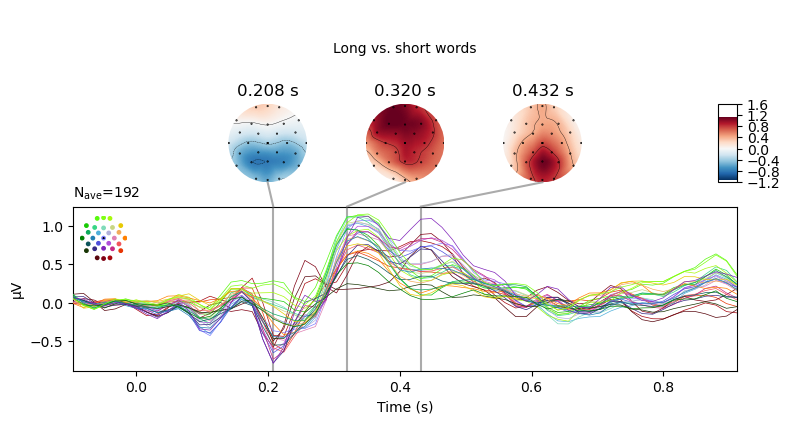

In [15]:
# # We need an evoked object to plot the image to be masked
evoked = mne.combine_evoked([long_words.average(), short_words.average()],
                            weights=[1, -1])  # calculate difference wave
time_unit = dict(time_unit="s")
evoked.plot_joint(title="Long vs. short words", ts_args=time_unit,
                  topomap_args=time_unit);  # show difference wave

No projector specified for this dataset. Please consider the method self.add_proj.


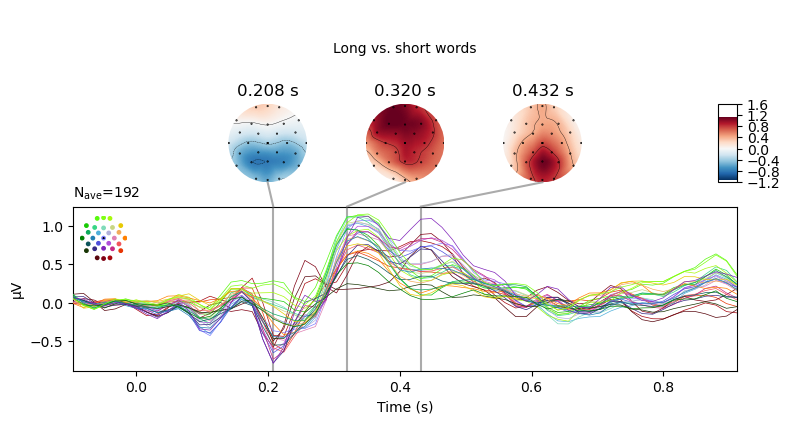

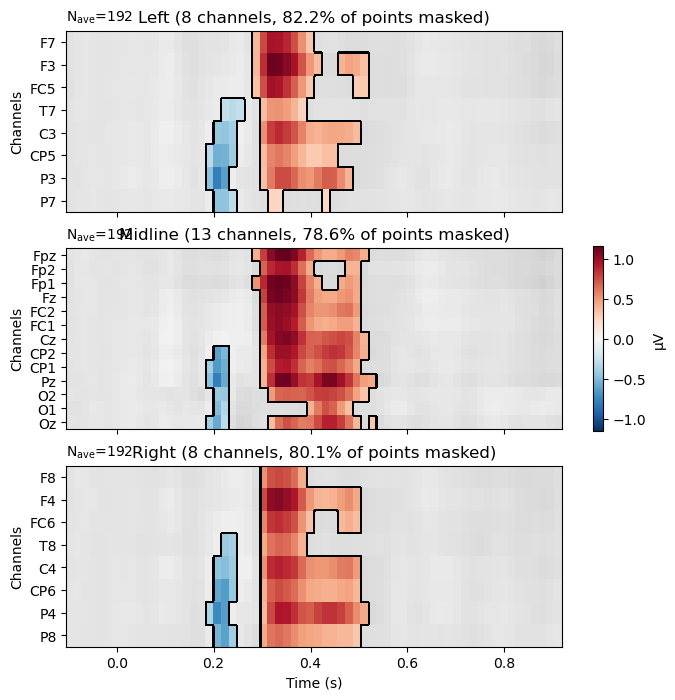

In [17]:
# We need an evoked object to plot the image to be masked
evoked = mne.combine_evoked([long_words.average(), short_words.average()],
                            weights=[1, -1])  # calculate difference wave
time_unit = dict(time_unit="s")
evoked.plot_joint(title="Long vs. short words", ts_args=time_unit,
                  topomap_args=time_unit)  # show difference wave

# Create ROIs by checking channel labels
selections = mne.channels.make_1020_channel_selections(evoked.info, midline="12z")

# Visualize the results
fig, axes = plt.subplots(nrows=3, figsize=(8, 8))
axes = {sel: ax for sel, ax in zip(selections, axes.ravel())}
evoked.plot_image(axes=axes, group_by=selections, colorbar=False, show=False,
                  mask=significant_points, show_names="all", titles=None,
                  **time_unit)
plt.colorbar(axes["Left"].images[-1], ax=list(axes.values()), shrink=.3,
             label="µV")

plt.show()